In [1]:
import h5py
import numpy as np

In [2]:
from e2c_train import create_e2c

from keras import backend as K
from keras.layers import Input
from keras.models import Model

Using TensorFlow backend.


In [35]:
# data_dir = '/data/cees/zjin/lstm_rom/datasets/9W_BHP/'
data_dir = '/data/cees/zjin/lstm_rom/datasets/9W_BHP_RATE/'

output_dir = '/data3/Astro/lstm_rom/e2c_larry/saved_models/' # load model data

case_name = '9w_bhp_rate'

# suffix = '_single_out_rel_2'
# suffix = '_fix_wl_rel_1'
case_suffix = '_fix_wl_rel_1' # the dataset being evaluated here
model_suffix = '_single_out_rel_3' # the dataset used to train the model
train_suffix = '_no_p'

eval_file = case_name + '_e2c_eval' + case_suffix + '_n2200_dt20day_nt22_nrun100.mat'

state_file = case_name + '_train_n_400_full'
ctrl_file = case_name + '_norm_bhps_n_400'

state_data = state_file + case_suffix + '.mat'
ctrl_data = ctrl_file + case_suffix + '.mat'

## Load E2C model

In [36]:
latent_dim, u_dim = 50, 9
input_shape = (60, 60, 1)
encoder, decoder, transition, sampler = create_e2c(latent_dim, u_dim, input_shape)

num_train, latent_dim, learning_rate, epoch = 6600, 50, 1e-4, 10

In [37]:
encoder.load_weights(output_dir + 'e2c_encoder_'+case_name+model_suffix+train_suffix+'_nt%d_l%d_lr%.0e_ep%d.h5' % (num_train, latent_dim, learning_rate, epoch))
decoder.load_weights(output_dir + 'e2c_decoder_'+case_name+model_suffix+train_suffix+'_nt%d_l%d_lr%.0e_ep%d.h5' % (num_train, latent_dim, learning_rate, epoch))
transition.load_weights(output_dir + 'e2c_transition_'+case_name+model_suffix+train_suffix+'_nt%d_l%d_lr%.0e_ep%d.h5' % (num_train, latent_dim, learning_rate, epoch))

## One step prediction

In [38]:
hf_r = h5py.File(data_dir + eval_file, 'r')
sat_t_eval = np.array(hf_r.get('sat_t'))
sat_t1_eval = np.array(hf_r.get('sat_t1'))
bhp_eval = np.array(hf_r.get('bhp'))
hf_r.close()

In [39]:
num_eval = 20 # pick 20 out of 2200 evals
sat_t_eval = sat_t_eval[:num_eval, ...]
sat_t1_eval = sat_t1_eval[:num_eval, ...]
bhp_eval = bhp_eval[:num_eval, ...]

In [40]:
print(sat_t_eval.shape)
print(sat_t1_eval.shape)
print(bhp_eval[:,:5].min().min())
print(bhp_eval[:,:5].max().max())

print(sat_t_eval.shape)

(20, 60, 60, 1)
(20, 60, 60, 1)
0.0022121047239354093
0.1664219482414829
(20, 60, 60, 1)


In [9]:
xt = Input(shape=input_shape)
xt1 = Input(shape=input_shape)
ut = Input(shape=(u_dim, ))

In [41]:
zt_mean, zt_logvar = encoder(xt)
zt = sampler([zt_mean, zt_logvar])
xt_rec = decoder(zt)

zt1_pred, zt1_mean_pred = transition([zt, zt_mean, ut])
xt1_pred = decoder(zt1_pred)

e2c_model = Model([xt, ut], [xt_rec, xt1_pred])

In [42]:
[sat_t_rec, sat_t1_pred] = e2c_model.predict([sat_t_eval, bhp_eval])

In [43]:
print(sat_t_rec.shape)
print(sat_t1_pred.shape)

(20, 60, 60, 1)
(20, 60, 60, 1)


In [44]:
import matplotlib.pyplot as plt
plt.set_cmap('jet')

<Figure size 432x288 with 0 Axes>

In [45]:
print(sat_t_eval.max())
print(sat_t_eval.min())

0.6722
0.100069


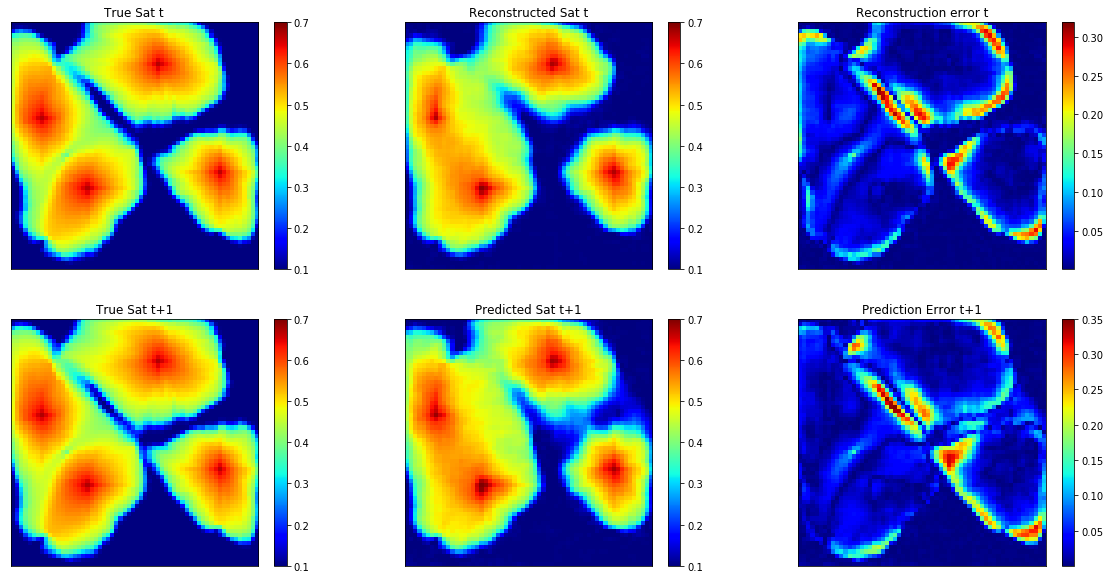

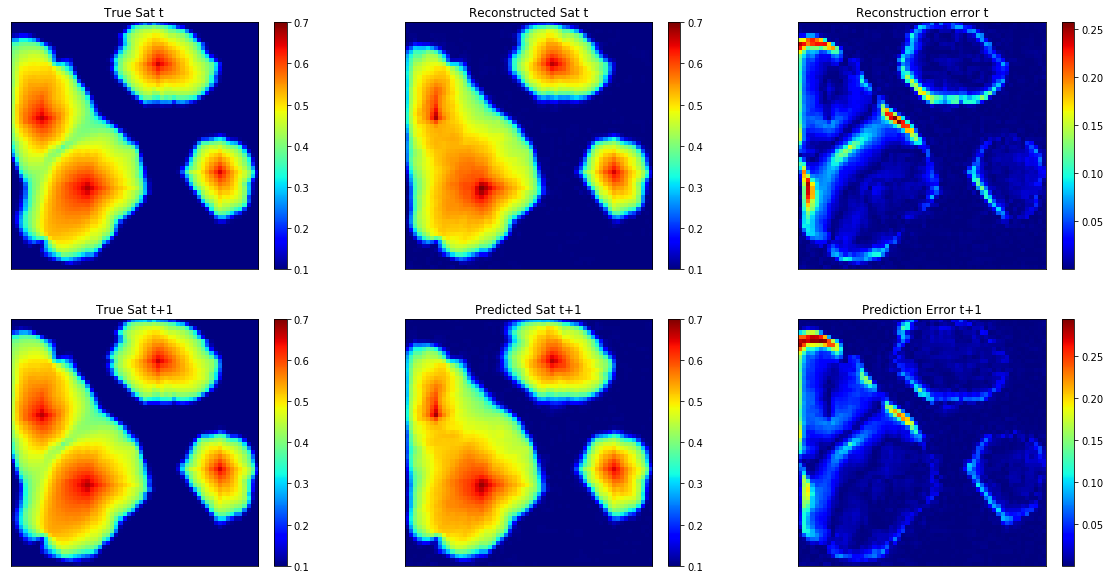

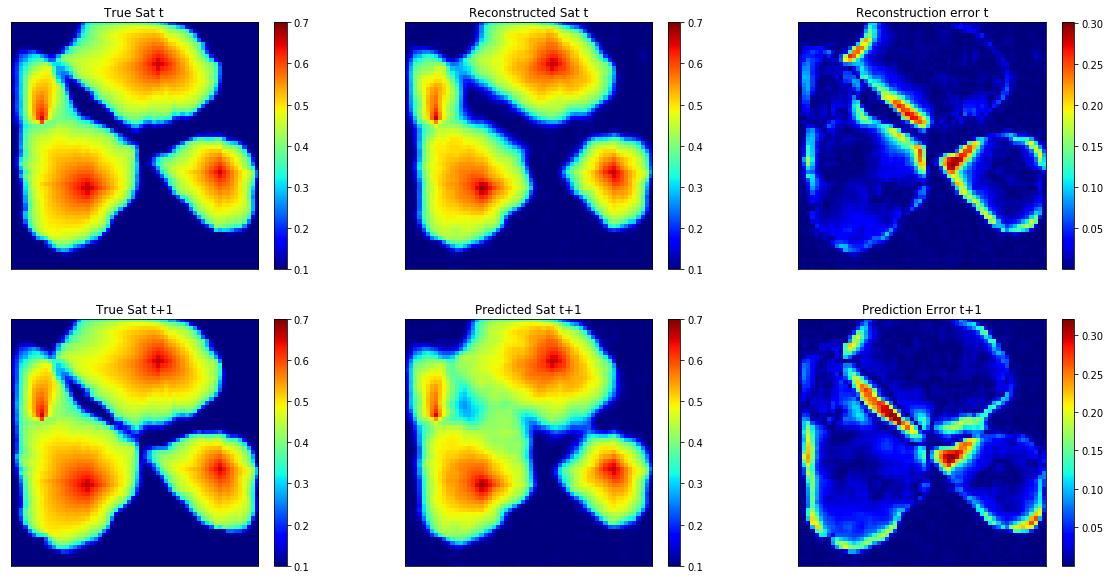

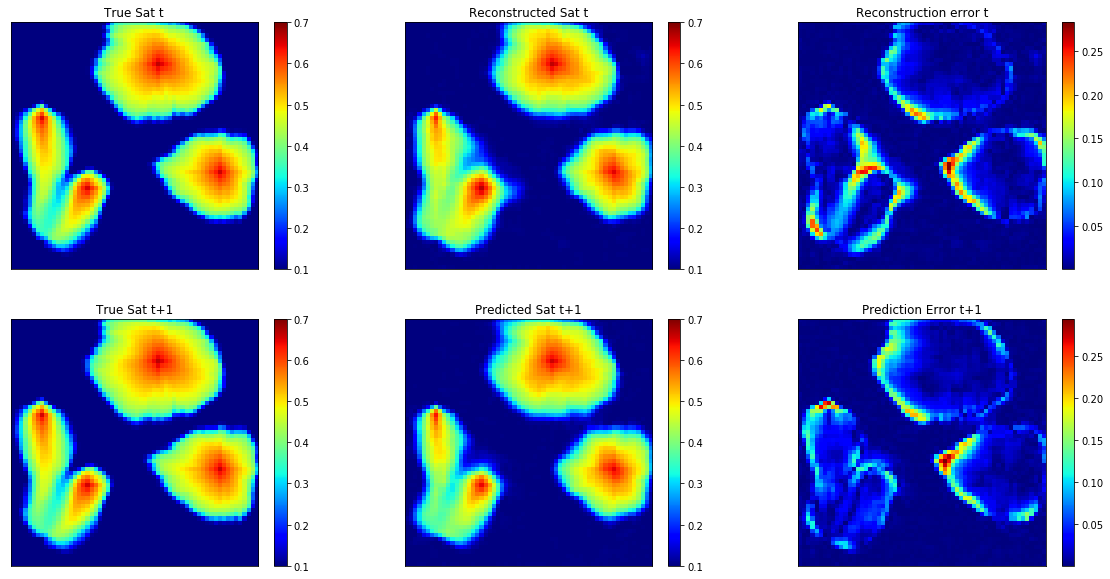

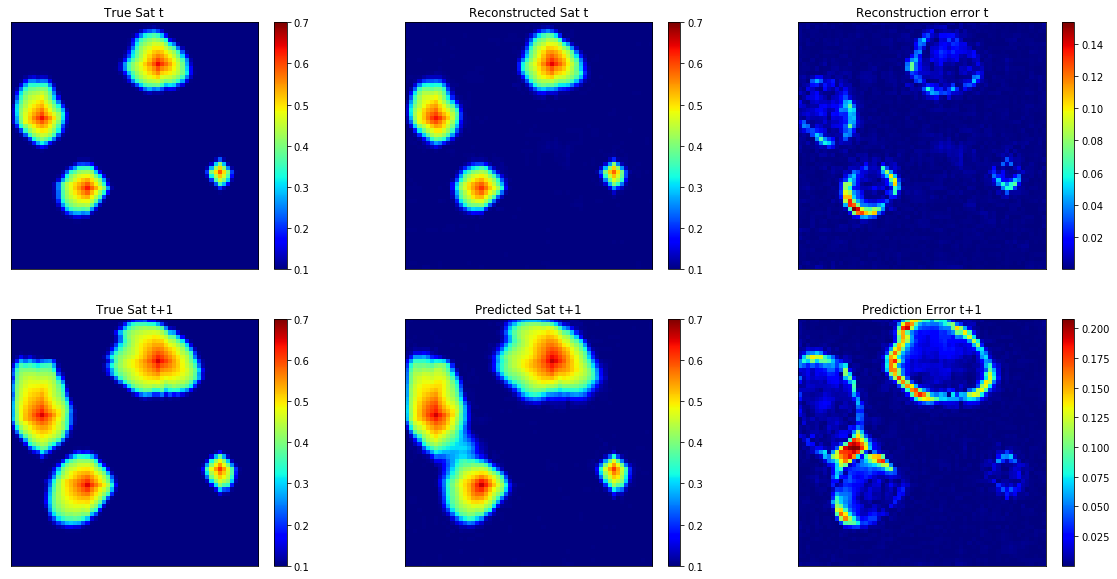

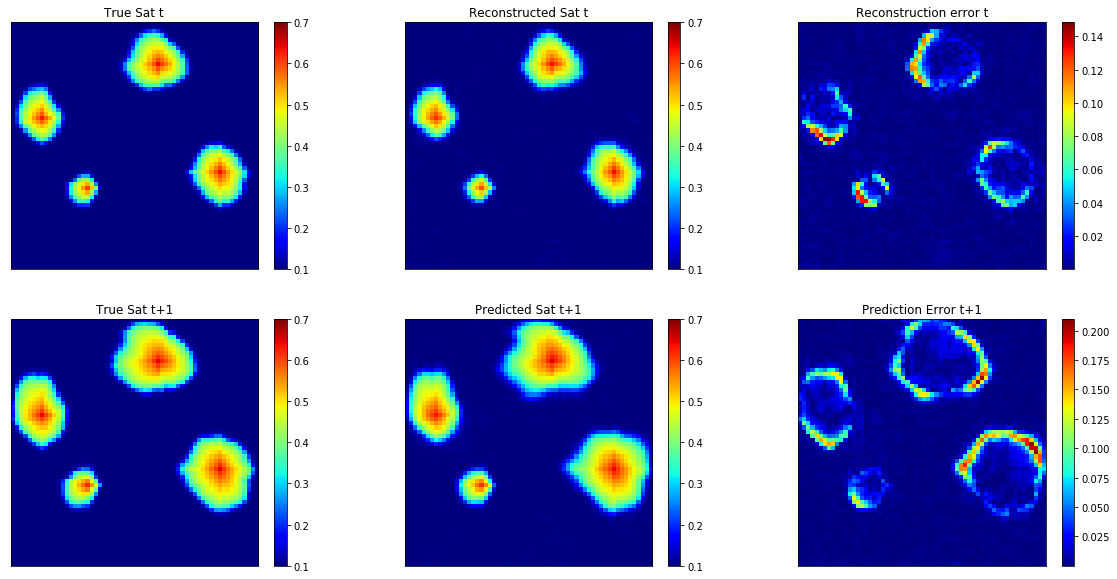

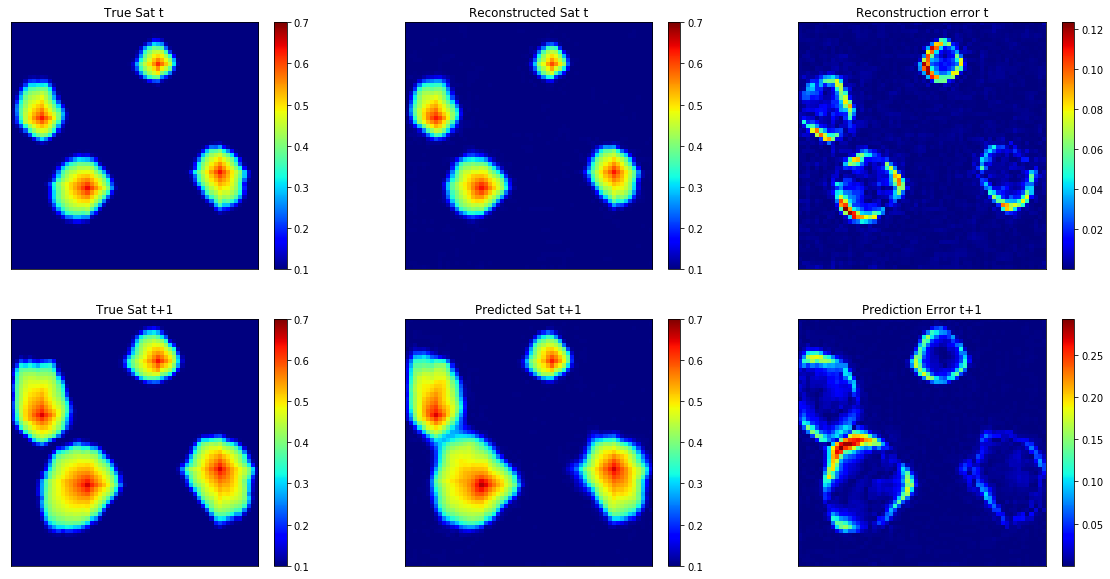

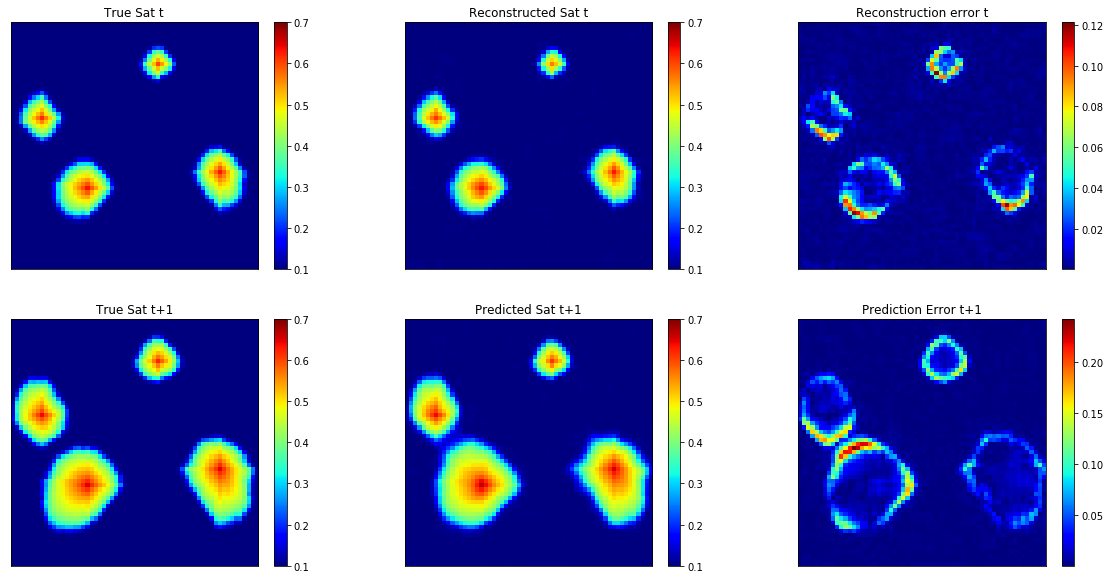

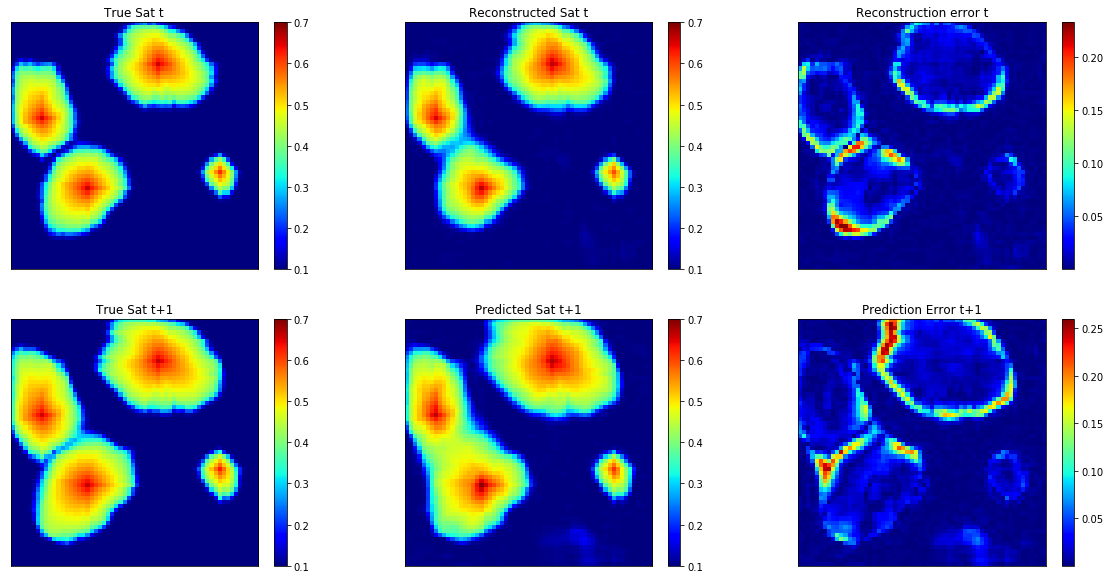

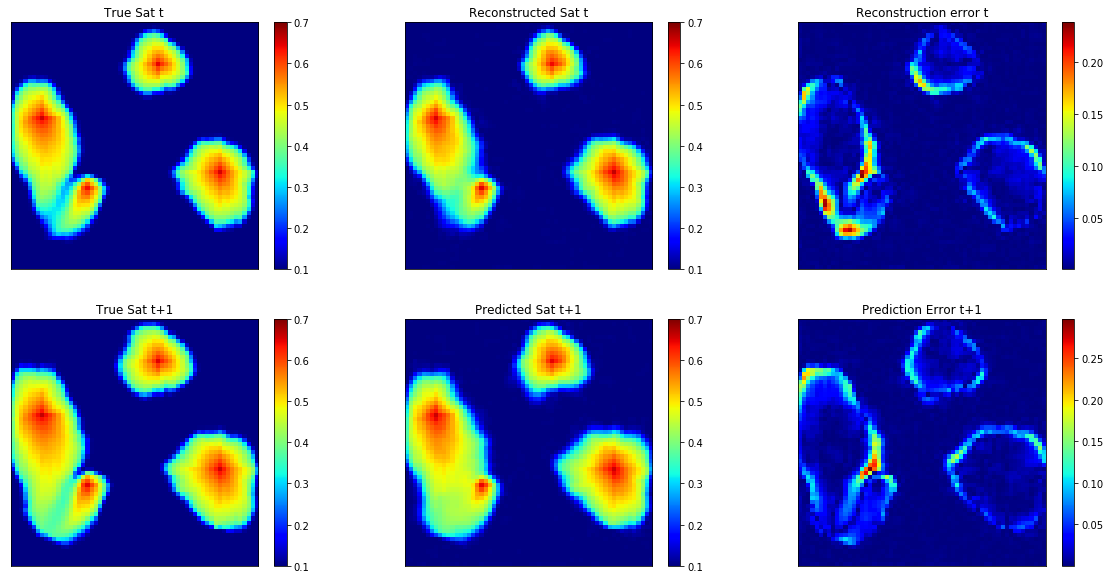

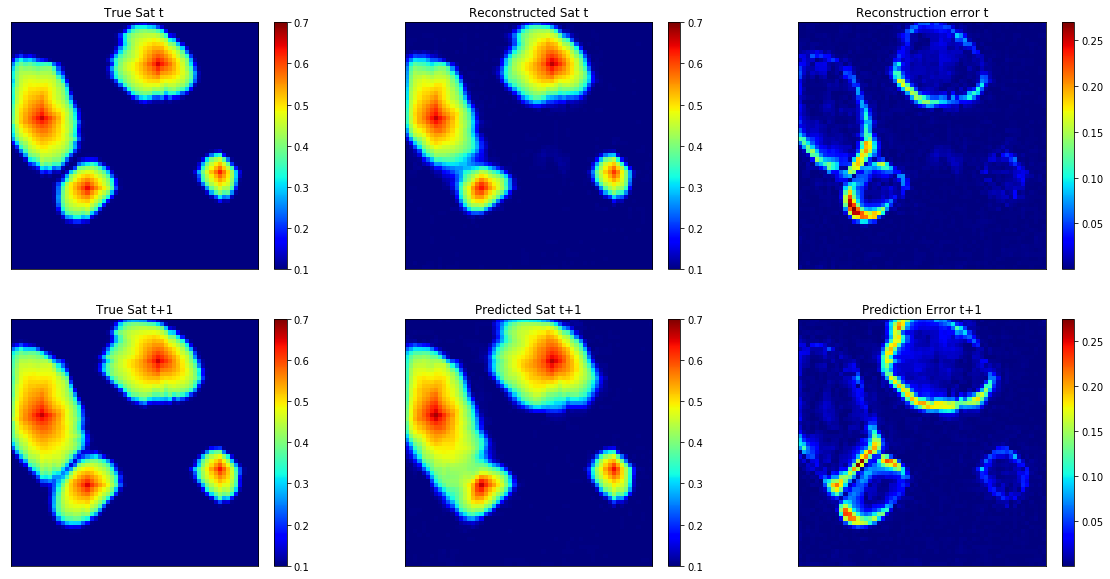

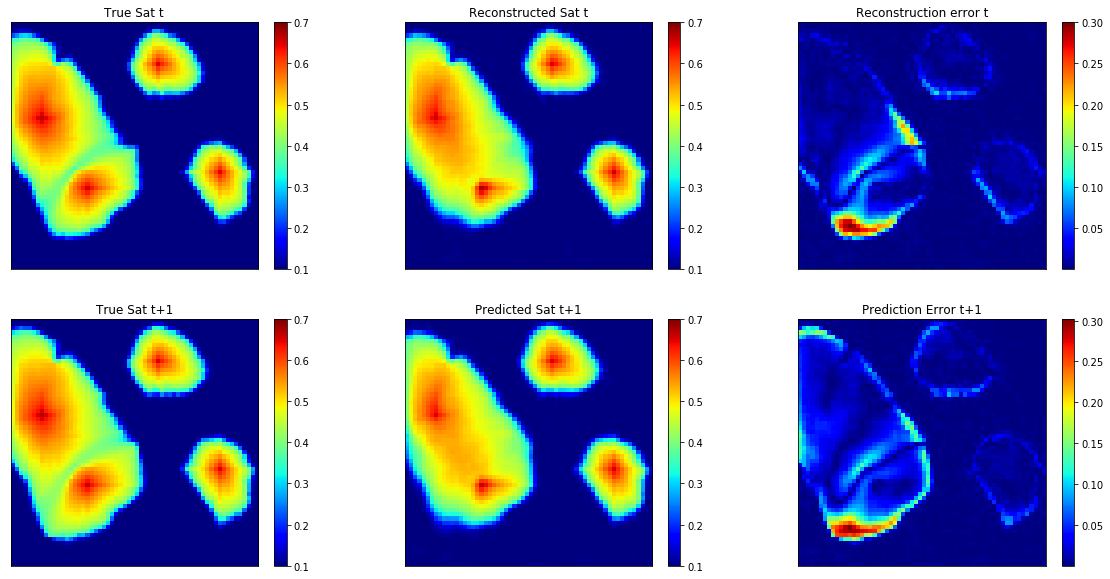

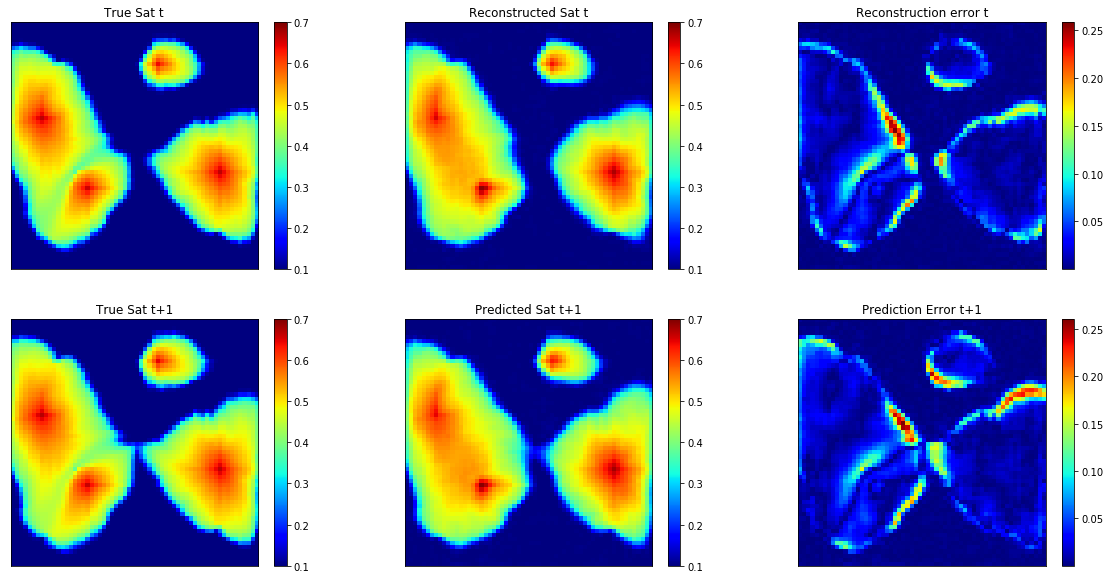

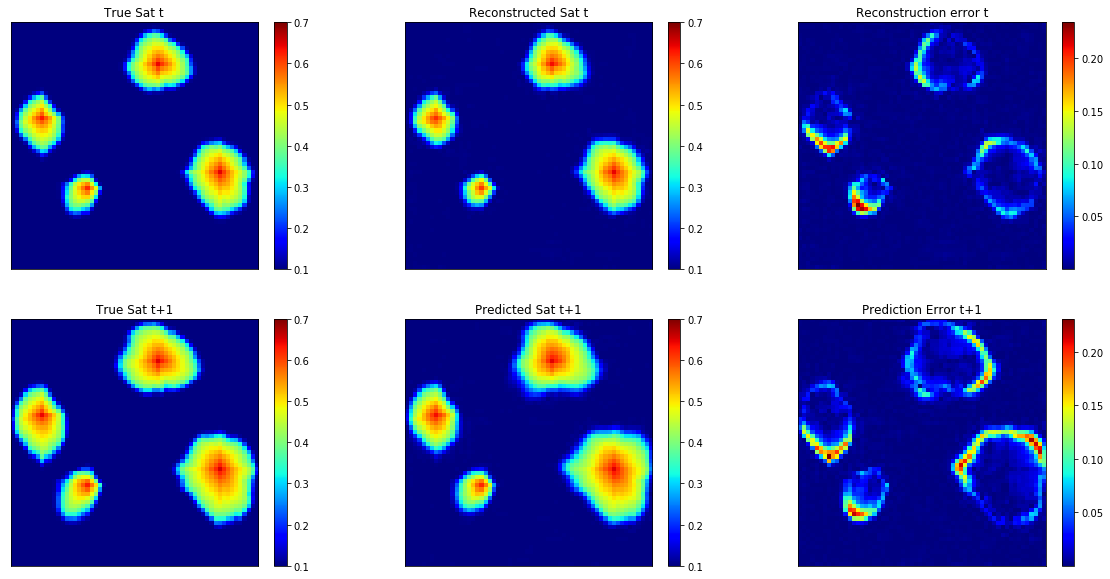

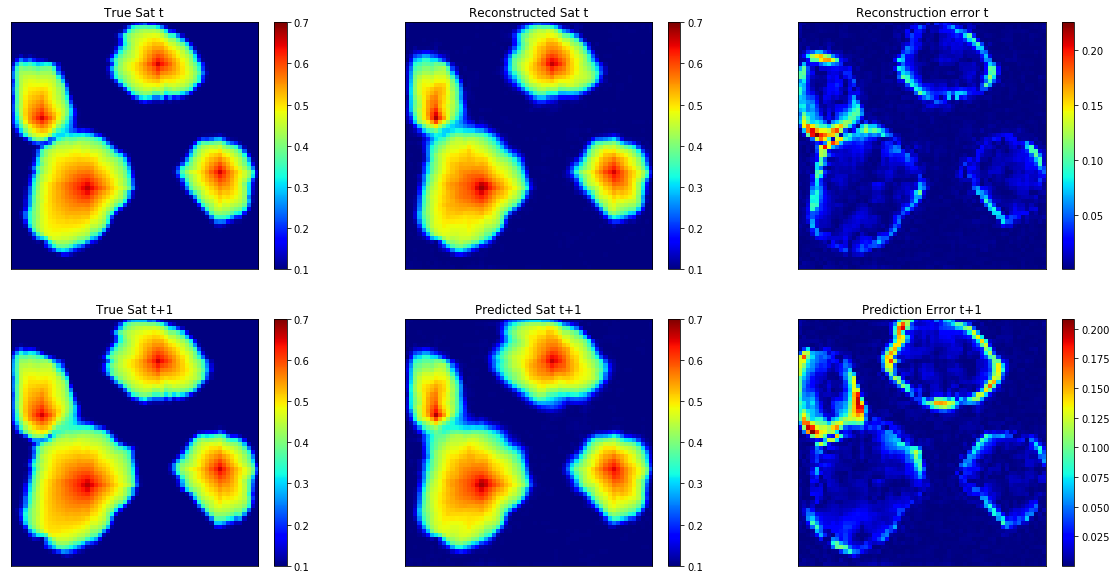

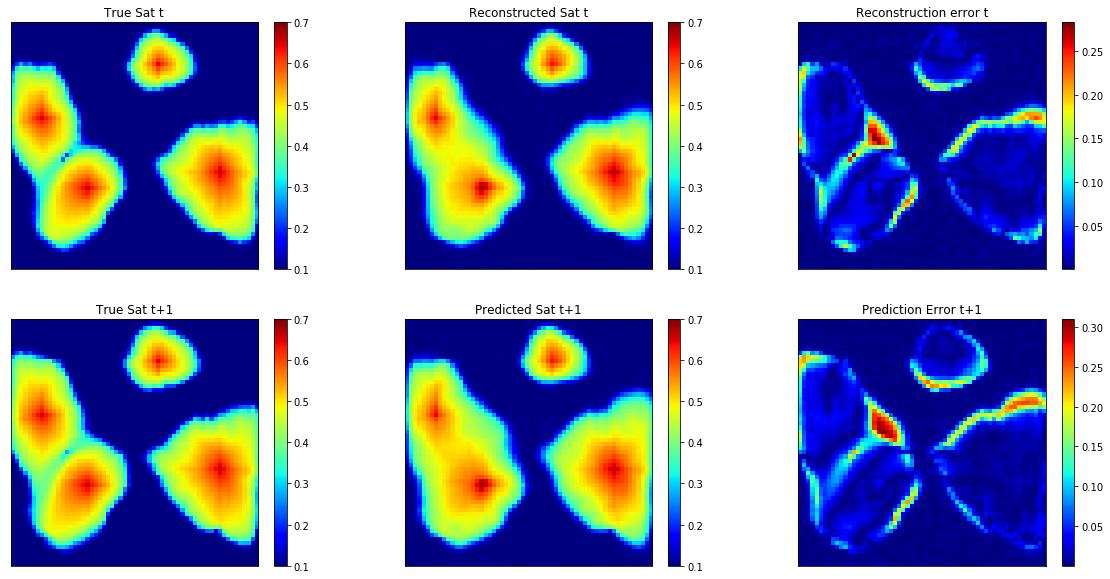

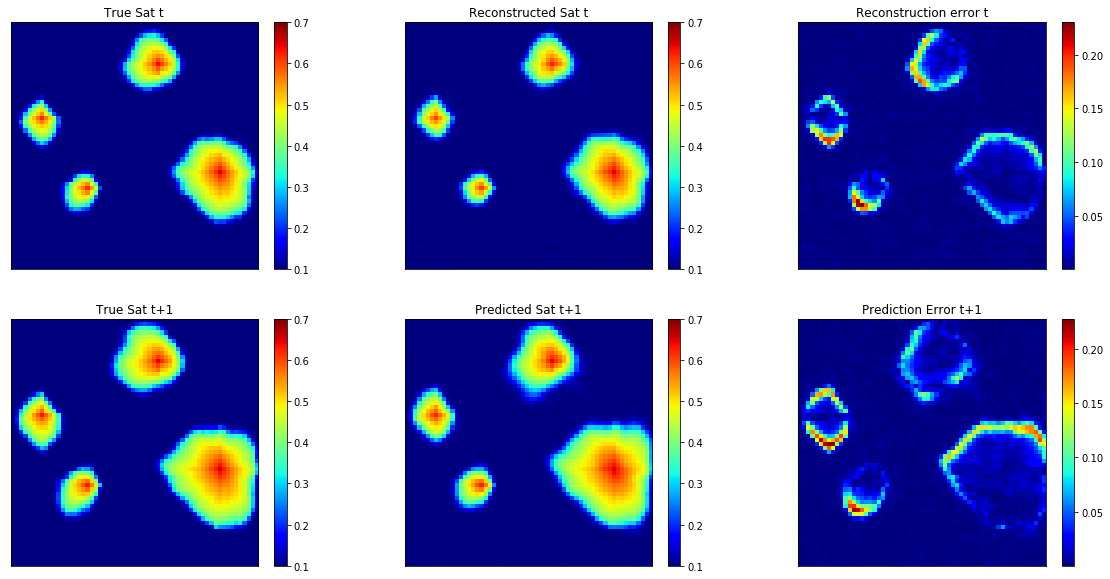

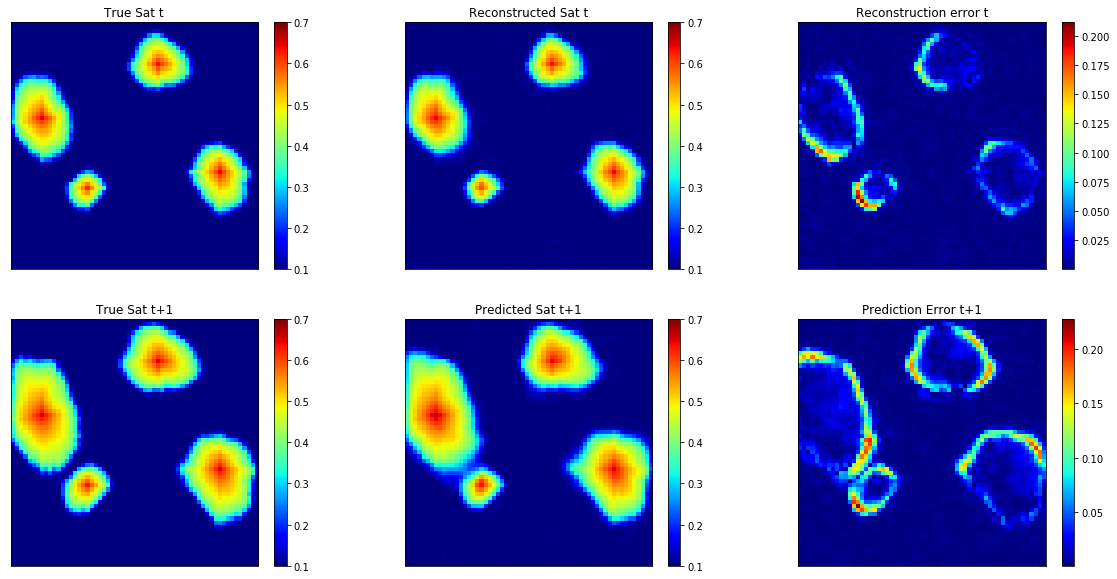

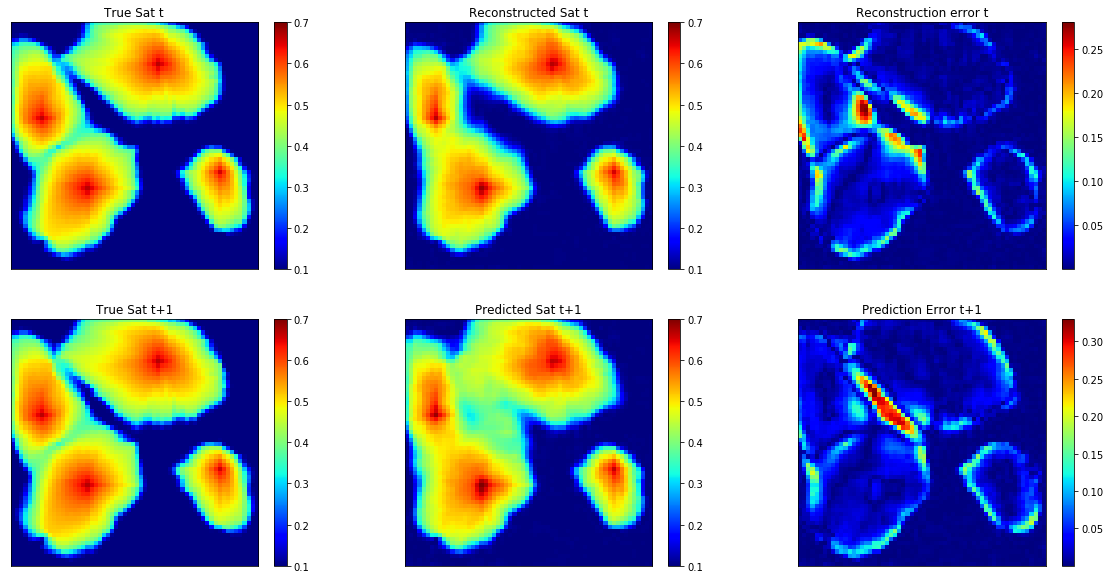

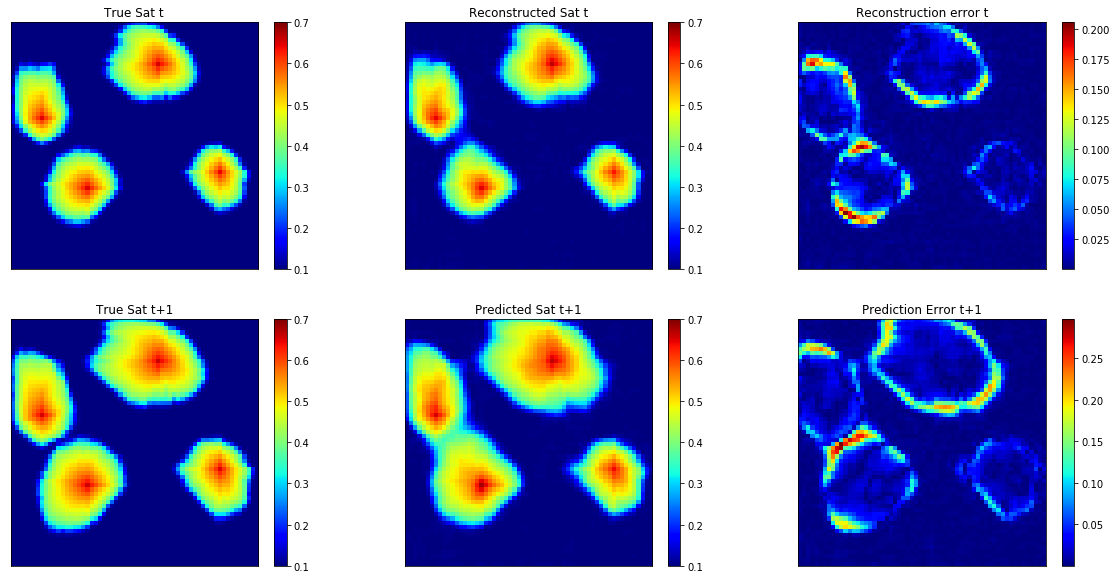

In [46]:
for k in range(num_eval):
    plt.figure(figsize=(20,10))
    plt.subplot(2, 3, 1)
    plt.imshow(sat_t_eval[k, :, :, 0])
    plt.clim([0.1, 0.7])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('True Sat t')
    
    plt.subplot(2, 3, 2)
    plt.imshow(sat_t_rec[k, :, :, 0])
    plt.clim([0.1, 0.7])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Reconstructed Sat t')
    
    plt.subplot(2, 3, 3)
    plt.imshow(np.fabs(sat_t_rec[k, :, :, 0] - sat_t_eval[k, :, :, 0]))
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Reconstruction error t')
    
    plt.subplot(2, 3, 4)
    plt.imshow(sat_t1_eval[k, :, :, 0])
    plt.clim([0.1, 0.7])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('True Sat t+1')
    
    plt.subplot(2, 3, 5)
    plt.imshow(sat_t1_pred[k, :, :, 0])
    plt.clim([0.1, 0.7])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Predicted Sat t+1')
    
    plt.subplot(2, 3, 6)
    plt.imshow(np.fabs(sat_t1_pred[k, :, :, 0] - sat_t1_eval[k, :, :, 0]))
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Prediction Error t+1')
plt.show()

## Sequential prediction

In [47]:
hf_r = h5py.File(data_dir + state_data, 'r')
sat = np.array(hf_r.get('sat'))
hf_r.close()

In [48]:
hf_r = h5py.File(data_dir + ctrl_data, 'r')
bhp0 = np.array(hf_r.get('bhp'))
rate0 = np.array(hf_r.get('rate'))
hf_r.close()
# bhp -= 0.45

In [49]:
bhp = np.concatenate((bhp0,rate0),axis=1)
print(bhp.shape)

(400, 9)


In [50]:
sat = sat.T.reshape((400, 100, 3600))

In [66]:
ind_case = [1, 101, 201, 301]

In [67]:
num_case = 4
num_tstep = 10
sat_pred = np.zeros((num_case, num_tstep, 60, 60))

In [68]:
bhp_seq = bhp[ind_case, :]

In [69]:
sat0_seq = sat[ind_case, 4, :].reshape((num_case, 60, 60, 1))

In [70]:
sat0_seq.shape

(4, 60, 60, 1)

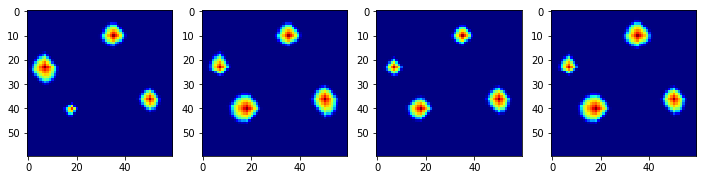

In [71]:
plt.figure(figsize=(12,3))
for k in range(num_case):
    plt.subplot(1,4,k+1)
    plt.imshow(sat0_seq[k, :, :, 0])
plt.show()

In [72]:
sat_t_seq = sat[ind_case, 4, :].reshape((num_case, 60, 60, 1))

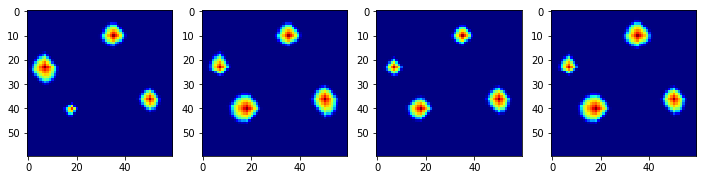

In [73]:
plt.figure(figsize=(12,3))
for k in range(num_case):
    plt.subplot(1,4,k+1)
    plt.imshow(sat_t_seq[k, :, :, 0])
plt.show()

In [74]:
print(sat_t_seq.shape)
print(sat_pred.shape)
print(bhp_seq.shape)

(4, 60, 60, 1)
(4, 10, 60, 60)
(4, 9)


In [75]:
for i_tstep in range(10):
    sat_pred[:, i_tstep, ...] = sat_t_seq[:,:,:,0].copy()
    [_, sat_t1_seq] = e2c_model.predict([sat_t_seq, bhp_seq])
    sat_t_seq = sat_t1_seq.copy()

In [76]:
t_steps = list(np.arange(4,104,10))
print(t_steps)
# num_tstep = len(t_steps)

[4, 14, 24, 34, 44, 54, 64, 74, 84, 94]


In [77]:
sat.shape

(400, 100, 3600)

In [78]:
sat_seq_true = sat[ind_case, ...]
sat_seq_true = sat_seq_true[:, list(np.arange(4,104,10)), :]
sat_seq_true.shape

(4, 10, 3600)

Case num: 1


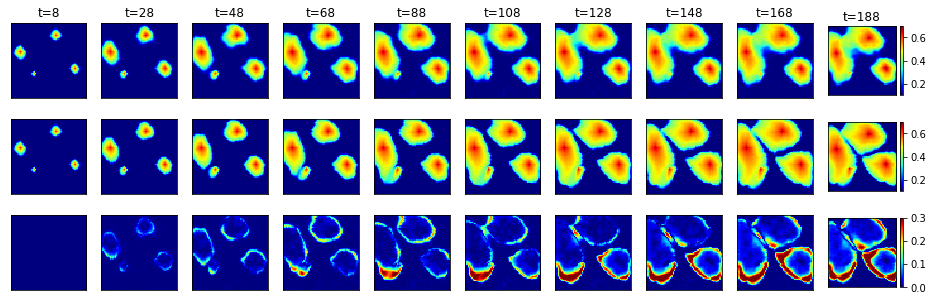

Case num: 101


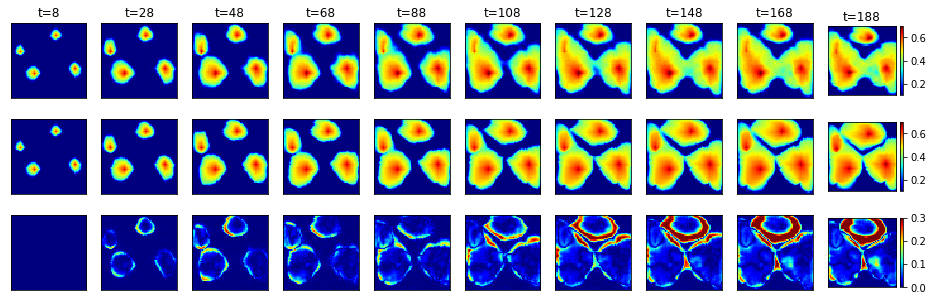

Case num: 201


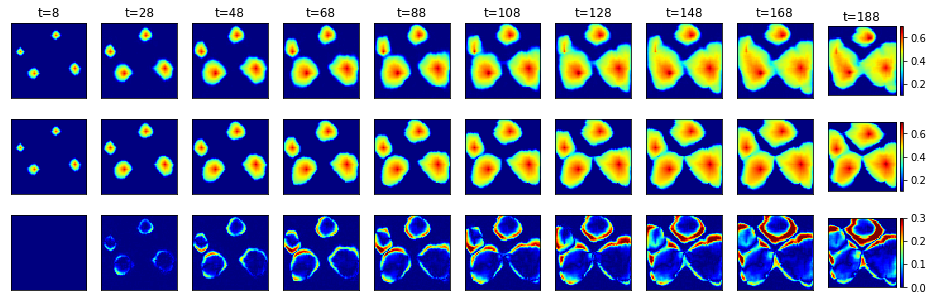

Case num: 301


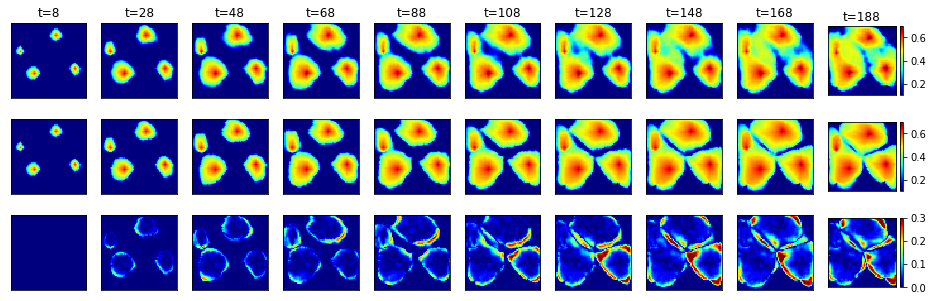

In [79]:
for k in range(4):
    print("Case num: %d"%ind_case[k])
    plt.figure(figsize=(16,5))
    for i_tstep in range(len(t_steps)):
        plt.subplot(3, num_tstep, i_tstep+1)
        plt.imshow(sat_pred[k, i_tstep, ...])
        plt.title('t=%d'%(t_steps[i_tstep]*2))
        plt.xticks([])
        plt.yticks([])
        plt.clim([0.1, 0.70])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046) 
            
        
        plt.subplot(3, num_tstep, i_tstep+1+num_tstep)
        plt.imshow(sat_seq_true[k, i_tstep, :].reshape((60,60)))
        plt.xticks([])
        plt.yticks([])
        plt.clim([0.1, 0.70])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046)         
        
        plt.subplot(3, num_tstep, i_tstep+1+2*num_tstep)
        plt.imshow(np.fabs(sat_seq_true[k, i_tstep, :].reshape((60,60)) - sat_pred[k, i_tstep, ...]))
        plt.xticks([])
        plt.yticks([])
        plt.clim([0, 0.30])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046) 

    plt.show()